In [3]:
from base import *
from utils import *
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import PauliSumOp, AerPauliExpectation
from qiskit.circuit import Parameter
import numpy as np
import seaborn as sns



## The simple hamiltonian
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad \mathcal{E} = \frac{E_1
  + E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
c = (V_{11}+V_{22})/2, 
$$ 
$$
\omega_z = (V_{11}-V_{22})/2, 
$$
$$
\omega_x = V_{12}=V_{21}
$$

In [4]:
# Constants
E_1 = 0
E_2 = 4 
V_11 = 3
V_22 = -3
V_12 = 0.2
V_21 = 0.2
epsilon = (E_1+E_2) / 2
Omega = (E_1-E_2) / 2
c = (V_11 + V_22) / 2
omega_z = (V_11 - V_22) / 2
omega_x = V_12

# Variables
# lmb = 1 # Interaction strength


### Classical numerical solver for the eigenvalues

In [5]:
H_0 = np.array([[E_1, 0],
               [0, E_2]])
H_1 = np.array([[V_11, V_12],
               [V_21, V_22]])


lmbs = np.arange(0, 1, 0.001)
eigs = np.zeros((2, len(lmbs)))

for i, lmb in enumerate(lmbs):
    result = np.linalg.eig(H_0 + lmb * H_1)[0]
    eigs[:,i] = max(result), min(result)

# print(eigs)
# print(lmbs.shape)
plt.plot(lmbs, eigs[0], label='E_0')
plt.plot(lmbs, eigs[1], label='E_1')
plt.plot(np.array([2/3 for _ in range(100)]), np.linspace(0, 4, 100), label=r'$\lambda=2/3$'),
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Eigenvalues')
plt.legend()
save_fig('eigs-cl.pdf')


### Quantum Computing 

First we need to rewrite the hamiltonian in terms of Pauli matrices.
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad 
\mathcal{E} = \frac{E_1+ E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
\lambda H_I = \lambda c \boldsymbol{I} + \lambda \omega_z\sigma_z + \lambda \omega_x \sigma_x 
$$
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [6]:
q2 = Qubits_2()

# set up bell state
q2.hadamard(0)
q2.measure(1000)

[(462, '00'), (0, '01'), (538, '10'), (0, '11')]

Set up

In [7]:

def H(lmb):
    return PauliSumOp.from_list([('X', lmb*omega_x), 
                                 ('Z', Omega+lmb*omega_z), 
                                 ('I', lmb*c+epsilon)]) # Hamiltonian using operators

def ansatz():
    # creates an ansatz that are functions of the parameters TODO: maybe can be changed to Hartree Fock initial state? 
    # from HartreeFock.construct_circuit()
    theta = Parameter('theta')
    phi = Parameter('phi')
    qc = QuantumCircuit(1)
    qc.rx(theta,0)
    qc.ry(phi,0)
    return qc


def prep_vqe():
    adam = ADAM(maxiter = 10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=adam, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.



In [8]:
# Define the backend to run the quantum circuit
n_points=10


lmbs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe()
energies = np.zeros(n_points) # containers for the energies

for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    ham = H(lmb)
    print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'lmb = {lmb}, energy = {result.eigenvalue.real}')




0.0 * X
- 2.0 * Z
+ 2.0 * I
lmb = 0.0, energy = 4.6904258255153763e-11
0.020000000000000004 * X
- 1.7 * Z
+ 2.0 * I
lmb = 0.1, energy = 0.2998823570417146
0.04000000000000001 * X
- 1.4 * Z
+ 2.0 * I
lmb = 0.2, energy = 0.5994286880149327
0.06 * X
- 1.1 * Z
+ 2.0 * I
lmb = 0.3, energy = 0.898364851709005
0.08000000000000002 * X
- 0.7999999999999998 * Z
+ 2.0 * I
lmb = 0.4, energy = 1.196009950326411
0.1 * X
- 0.5 * Z
+ 2.0 * I
lmb = 0.5, energy = 1.4900980486546627
0.12 * X
- 0.20000000000000018 * Z
+ 2.0 * I
lmb = 0.6, energy = 1.7667619242114903
0.13999999999999999 * X
+ 0.09999999999999964 * Z
+ 2.0 * I
lmb = 0.7, energy = 1.8279534946624456
0.16000000000000003 * X
+ 0.40000000000000036 * Z
+ 2.0 * I
lmb = 0.8, energy = 1.569186815441408
0.18000000000000002 * X
+ 0.7000000000000002 * Z
+ 2.0 * I
lmb = 0.9, energy = 1.2772275600305458


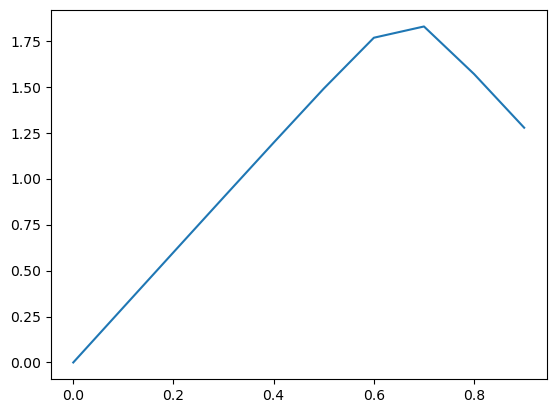

In [9]:
plt.plot(lmbs/n_points, energies)
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [10]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [theta, phi]'''
    qc = Qubit()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    return qc

def my_H(lmb):
    # computes the hamiltonian
    return pauli_sum([('X', lmb*omega_x), 
                      ('Z', Omega+lmb*omega_z), 
                      ('I', lmb*c+epsilon)])




In [11]:
a = my_ansatz((np.pi/2,np.pi/2))
a

Qubit(s) in state: 
 0.50+0.50j|0⟩ + 0.50-0.50j|1⟩ 

In [12]:
from algorithms import Vqe 

In [13]:
n_points = 10

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=2)
my_vqe = Vqe(my_ansatz, init_points)

my_energies = np.zeros(n_points)
lmbs = np.arange(n_points)
for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    print(lmb)
    my_ham = my_H(lmb)
    print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham)
    print(f"lambda: {lmb}, energy: {min_energy}")
    my_energies[i] = min_energy

#TODO: why does it need to be adjusted?
if min(my_energies) < 0:
    my_energies += -min(my_energies)


0.0
[[0. 0.]
 [0. 4.]]
lambda: 0.0, energy: -3.99999999999881
0.1
[[0.3  0.02]
 [0.02 3.7 ]]
lambda: 0.1, energy: -3.700117642988245
0.2
[[0.6  0.04]
 [0.04 3.4 ]]
lambda: 0.2, energy: -3.4005713120009275
0.3
[[0.9  0.06]
 [0.06 3.1 ]]
lambda: 0.3, energy: -3.1016351483136195
0.4
[[1.2  0.08]
 [0.08 2.8 ]]
lambda: 0.4, energy: -2.803990049689671
0.5
[[1.5 0.1]
 [0.1 2.5]]
lambda: 0.5, energy: -2.5099019513592746
0.6
[[1.8  0.12]
 [0.12 2.2 ]]
lambda: 0.6, energy: -2.2332380757925585
0.7
[[2.1  0.14]
 [0.14 1.9 ]]
lambda: 0.7, energy: -2.172046505339981
0.8
[[2.4  0.16]
 [0.16 1.6 ]]
lambda: 0.8, energy: -2.430813184570364
0.9
[[2.7  0.18]
 [0.18 1.3 ]]
lambda: 0.9, energy: -2.722772439982577


/Users/bukser/mambaforge/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/bukser/mambaforge/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


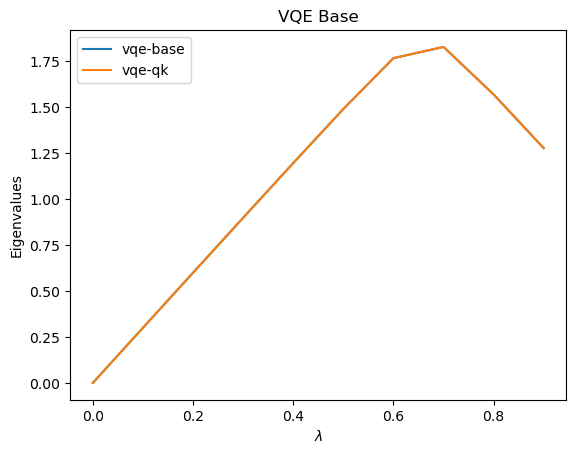

In [14]:

plt.plot(lmbs/n_points, my_energies, label='vqe-base')
plt.plot(lmbs/n_points, energies, label='vqe-qk')
# plt.plot(2/3* np.ones(n_points), np.linspace(min(my_energies), 1.01*max(my_energies), n_points), label=r'$\lambda=2/3$')

plt.xlabel(r'$\lambda$')
plt.ylabel('Eigenvalues')
plt.title('VQE Base')
plt.legend()
plt.show()